In [1]:
import graphlab
import glob
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileList= glob.glob("../data/*.*")
fileList

['../data\\RegularSeasonCompactResults.csv',
 '../data\\RegularSeasonDetailedResults.csv',
 '../data\\sample_submission.csv',
 '../data\\Seasons.csv',
 '../data\\Teams.csv',
 '../data\\TourneyCompactResults.csv',
 '../data\\TourneyDetailedResults.csv',
 '../data\\TourneySeeds.csv',
 '../data\\TourneySlots.csv']

# Read in Tournament Seeds

In [3]:
column_type_hints=[long,long,long,long,long,long,str,long]
tSeed= graphlab.SFrame.read_csv(fileList[7], verbose=False)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\edwardsd\AppData\Local\Temp\2\graphlab_server_1487522979.log.0


This non-commercial license of GraphLab Create for academic use is assigned to david.edwards@act.org and will expire on September 14, 2017.


# Some seeds were introduced in later years
like W1a

In [4]:
tSeed.groupby(key_columns='Seed', operations={'count':graphlab.aggregate.COUNT()})\
.sort('count', ascending=True)

Seed,count
Y12a,1
W12a,1
W12b,1
Z14a,1
Z14b,1
X12a,1
Z13b,1
X12b,1
Z13a,1
Y12b,1


## How many different seeds appeared how many number of times?
`numSeeds` (distinct seed names) appeared `count` number of times

In [5]:
tSeed.groupby(key_columns='Seed', operations={'count':graphlab.aggregate.COUNT()})\
.sort('count', ascending=True)\
.groupby(key_columns='count', operations={'numSeeds':graphlab.aggregate.COUNT_DISTINCT('Seed')}).sort('count')

count,numSeeds
1,10
2,4
3,2
4,2
5,4
8,2
24,1
27,2
28,1
29,1


# Read in the Tournament slots

In [6]:
column_type_hints=[long,long,long,long,long,long,str,long]
tSlot= graphlab.SFrame.read_csv(fileList[8], verbose=False)

# What games were played in previous tournaments?

In [7]:
len(tSlot), len(tSeed)

(2050, 2082)

In [8]:
print(tSlot.head(2))
print(tSeed.head(2))

+--------+------+------------+----------+
| Season | Slot | Strongseed | Weakseed |
+--------+------+------------+----------+
|  1985  | R1W1 |    W01     |   W16    |
|  1985  | R1W2 |    W02     |   W15    |
+--------+------+------------+----------+
[2 rows x 4 columns]

+--------+------+------+
| Season | Seed | Team |
+--------+------+------+
|  1985  | W01  | 1207 |
|  1985  | W02  | 1210 |
+--------+------+------+
[2 rows x 3 columns]



In [9]:
def doRound(slots,seeds,games):

    ###
    roundSlots= slots\
    .join(seeds, on={'Season':'Season', 'Strongseed':'Seed'})\
    .rename({'Team':'Strongteam'})\
    .join(seeds, on={'Season':'Season', 'Weakseed':'Seed'})\
    .rename({'Team':'Weakteam'})\
    ###

    ###
    seedWins= games.join(roundSlots, on={'Season': 'Season', 'Wteam': 'Strongteam', 'Lteam':'Weakteam'})
    seedWins['outcome']= seedWins.apply(lambda x: 'W')
    #print(seedWins.head())
    seedUpsets= games.join(roundSlots, on={'Season': 'Season', 'Lteam': 'Strongteam', 'Wteam':'Weakteam'})
    seedUpsets['outcome']= seedUpsets.apply(lambda x: 'L')
    #print(seedUpsets.head())
    ###

    ###
    #print(len(seedWins)>0,len(seedUpsets)>0)
    if len(seedWins)>0 and len(seedUpsets)>0:
        round2Slots= seedWins.append(seedUpsets)['Season','Slot','Wteam'].rename({'Wteam':'Team', 'Slot':'Seed'})
    elif len(seedWins)>0:
        round2Slots= seedWins['Season','Wteam','Slot'].rename({'Wteam':'Team', 'Slot':'Seed'})
    else:
        round2Slots= seedUpsets['Season','Wteam','Slot'].rename({'Wteam':'Team', 'Slot':'Seed'})
    ###

    ###
    return round2Slots
    ###

    ###
    ###

    ###
    ###

# Read in the `Compact Tournament` Game Data

In [10]:
column_type_hints=[long,long,long,long,long,long,str,long]
tscr= graphlab.SFrame.read_csv(fileList[5], verbose=False)

###### Since the SEED is only assigned in round 1, will need to do some more work to figure out which games were played in later rounds

In [11]:
tSeason= tSlot.filter_by(1987,'Season')
tSeasonSeed= tSeed.filter_by(1987,'Season')
r1= doRound(tSeason, tSeasonSeed, tscr)
r2= doRound(tSeason, r1, tscr)
r3= doRound(tSeason, r2, tscr)
r4= doRound(tSeason, r3, tscr)
r5= doRound(tSeason, r4, tscr)

In [12]:
#print(tSeasonSeed.head(2))
#print(r1.head(2))
#print(r2.head(2))
#print(r3.head(2))
#print(r4.head(2))
#print(r5.head(2))
allSeasonSeeds= tSeasonSeed.append(r1).append(r2).append(r3).append(r4).append(r5)

In [13]:
import re
pattern= re.compile('R*\d([WXYZ]([WXYZ]|\d+))')
allSeasonSeeds['slotbreakdown']= allSeasonSeeds['Seed'].apply(lambda x: re.findall(pattern, x))
allSeasonSeeds['slotbreakdown_len']= allSeasonSeeds['slotbreakdown'].apply(lambda x: len(x[0]) if len(x)==1 else 0)

In [14]:
allSeasonSeeds.sort('slotbreakdown_len', ascending=False)

Season,Seed,Team,slotbreakdown,slotbreakdown_len
1987,R1X5,1242,"[[X5, 5]]",2
1987,R1X8,1326,"[[X8, 8]]",2
1987,R1X4,1283,"[[X4, 4]]",2
1987,R1Y7,1261,"[[Y7, 7]]",2
1987,R1Y4,1462,"[[Y4, 4]]",2
1987,R1Z5,1461,"[[Z5, 5]]",2
1987,R1W8,1276,"[[W8, 8]]",2
1987,R1Z8,1243,"[[Z8, 8]]",2
1987,R1X3,1122,"[[X3, 3]]",2
1987,R1Z7,1431,"[[Z7, 7]]",2


# Read in the Compact Game Data

In [15]:
column_type_hints=[long,long,long,long,long,long,str,long]
rscr= graphlab.SFrame.read_csv(fileList[0], verbose=False)

In [16]:
tscr.groupby(key_columns=['Daynum'], operations={'count': graphlab.aggregate.COUNT()}).sort(['Daynum','count'])

Daynum,count
134,22
135,12
136,512
137,512
138,256
139,256
143,128
144,128
145,64
146,64


In [17]:
column_type_hints=[long,str]
teams= graphlab.SFrame.read_csv(fileList[4], verbose=False)

In [18]:
compact_cols=['Season', 'Daynum', 'Wteam', 'Wscore', 'Lteam', 'Lscore', 'Wloc', 'Numot']
#rscr.column_names()

##### Re-calculate `WLOC` column for the losing team

In [19]:
rscr['Lloc']= rscr['Wloc'].apply(lambda x: 'N' if x=='N' else 'H' if x=='A' else 'A')

In [20]:
print(rscr['Wloc'].unique())
print(rscr['Lloc'].unique())
print(rscr['Wloc','Lloc'].unique())

['H', 'A', 'N']
['H', 'A', 'N']
+------+------+
| Lloc | Wloc |
+------+------+
|  H   |  A   |
|  A   |  H   |
|  N   |  N   |
+------+------+
[3 rows x 2 columns]



In [21]:
len(rscr)

145289

In [22]:
rscr['Season'].unique().sort()

dtype: int
Rows: 32
[1985L, 1986L, 1987L, 1988L, 1989L, 1990L, 1991L, 1992L, 1993L, 1994L, 1995L, 1996L, 1997L, 1998L, 1999L, 2000L, 2001L, 2002L, 2003L, 2004L, 2005L, 2006L, 2007L, 2008L, 2009L, 2010L, 2011L, 2012L, 2013L, 2014L, 2015L, 2016L]

# Read in the Detailed Game Data

In [23]:
column_type_hints=[long,long,long,long
                   ,long,long,str,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long]
rsdr= graphlab.SFrame.read_csv(fileList[1], verbose=False)
rsdr= rsdr.add_row_number('game_id')
pass

In [24]:
column_type_hints=[long,long,long,long
                   ,long,long,str,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long,long,long
                   ,long,long]
tsdr= graphlab.SFrame.read_csv(fileList[6], verbose=False)
tsdr= tsdr.add_row_number('game_id')
pass

In [25]:
tsdr['Lloc']= tsdr['Wloc'].apply(lambda x: 'N' if x=='N' else 'H' if x=='A' else 'A')
rsdr['Lloc']= rsdr['Wloc'].apply(lambda x: 'N' if x=='N' else 'H' if x=='A' else 'A')

In [26]:
cols= rsdr.column_names()

### Define column groups for purposes later
* `game_cols` - columns related specifically to the game
* `compact_cols` - the column names in the `COMPACT` data file
* `team_cols` - columns related to each team in the `DETAIL` data file - prefix with `W` or `L` depending on win condition
* `stats_cols` - columns related to statistical measures of team performance

* `winStats`, `loseStats` - columns from `DETAIL` specific to winning or losing team

In [27]:
game_cols= ['Season', 'Daynum', 'Numot','game_id']
compact_cols=['Season', 'Daynum', 'Wteam', 'Wscore', 'Lteam', 'Lscore', 'Wloc', 'Numot']
team_cols=['team','score','loc','fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf']
stats_cols=['score','fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf']
winStats= ['W'+col for col in team_cols]
loseStats= ['L'+col for col in team_cols]

### Stack the `DETAIL` data file so there is one record per team per game (instead of one per game)

In [28]:
wins= rsdr[winStats+game_cols]\
.rename({a:b for a,b in zip(winStats,team_cols)})\
.add_column(graphlab.SArray([1 for x in range(len(rsdr))]),'y')

In [29]:
winsT= tsdr[winStats+game_cols]\
.rename({a:b for a,b in zip(winStats,team_cols)})\
.add_column(graphlab.SArray([1 for x in range(len(tsdr))]),'y')

In [30]:
losses= rsdr[loseStats+game_cols]\
.rename({a:b for a,b in zip(loseStats,team_cols)})\
.add_column(graphlab.SArray([0 for x in range(len(rsdr))]),'y')

In [31]:
lossesT= tsdr[loseStats+game_cols]\
.rename({a:b for a,b in zip(loseStats,team_cols)})\
.add_column(graphlab.SArray([0 for x in range(len(tsdr))]),'y')

In [32]:
rsdrTall= wins.append(losses)

In [33]:
tsdrTall= winsT.append(lossesT)

In [34]:
len(rsdrTall), len(tsdrTall)

(142482, 1828)

In [35]:
len(rsdr), len(tsdr)

(71241, 914)

In [36]:
tscr.groupby(key_columns=['Season','Daynum'], operations={'count': graphlab.aggregate.COUNT()})\
.unstack(column=['Daynum','count'], new_column_name='days')\
.unpack('days', column_name_prefix='')\
.sort('Season')
#.pack_columns(columns=['Daynum','count'], dtype=dict)\
#.unpack('X2')

Season,134,135,136,137,138,139,143,144,145,146,152,154
1985,None,None,16,16,8,8,4,4,2,2,2,1
1986,None,None,16,16,8,8,4,4,2,2,2,1
1987,None,None,16,16,8,8,4,4,2,2,2,1
1988,None,None,16,16,8,8,4,4,2,2,2,1
1989,None,None,16,16,8,8,4,4,2,2,2,1
1990,None,None,16,16,8,8,4,4,2,2,2,1
1991,None,None,16,16,8,8,4,4,2,2,2,1
1992,None,None,16,16,8,8,4,4,2,2,2,1
1993,None,None,16,16,8,8,4,4,2,2,2,1
1994,None,None,16,16,8,8,4,4,2,2,2,1


In [37]:
rsdr['Season'].unique().sort()

dtype: int
Rows: 14
[2003L, 2004L, 2005L, 2006L, 2007L, 2008L, 2009L, 2010L, 2011L, 2012L, 2013L, 2014L, 2015L, 2016L]

In [38]:
print(len(teams),len(rsdrTall['team'].unique()))

(364, 355)


# Create a team-level summary based on performance across all seasons

In [39]:
rsdrTeamSummary= rsdrTall.groupby(key_columns=['team'], operations={'count_games': graphlab.aggregate.COUNT()
                                                  ,'count_wins': graphlab.aggregate.SUM('y')
                                                  ,'avgScore': graphlab.aggregate.MEAN('score')
                                                  ,'firstSeason': graphlab.aggregate.MIN('Season')
                                                  ,'lastSeason': graphlab.aggregate.MAX('Season')
                                                  ,'numSeasons': graphlab.aggregate.COUNT_DISTINCT('Season')})

In [40]:
teams.join(rsdrTeamSummary, on={'Team_Id': 'team'})\
.filter_by(14,'numSeasons', exclude=True)\
.sort('lastSeason')
#.groupby(key_columns='numSeasons', operations={'count': graphlab.aggregate.COUNT()}).sort('numSeasons')

Team_Id,Team_Name,firstSeason,numSeasons,lastSeason,avgScore,count_games,count_wins
1289,Morris Brown,2003,1,2003,60.25,24,4
1128,Birmingham So,2003,4,2006,67.6698113208,106,67
1445,W Salem St,2007,4,2010,58.738317757,107,26
1147,Centenary,2003,9,2011,66.4176706827,249,63
1367,SC Upstate,2008,9,2016,65.8539325843,267,101
1295,N Dakota St,2006,11,2016,71.3311688312,308,186
1377,South Dakota,2009,8,2016,72.4666666667,210,89
1136,Bryant,2009,8,2016,64.5583333333,240,78
1223,Houston Bap,2008,9,2016,68.4705882353,238,65
1355,S Dakota St,2006,11,2016,71.1620795107,327,169


# Calculate several basic derived statistics for use later
* `fgm` - field goals made includes both 2-point and 3-point shots
* `%` - calculate shot percentages for `fgm2` etc...
* `poss` - calculate an approximate number of ball possessions

In [41]:
#rsdrTall.apply(lambda x: 3*x['fgm3']+2*(x['fgm']-x['fgm3'])+1*x['ftm']-x['score'])
rsdrTall['fgm2']= rsdrTall.apply(lambda x: x['fgm']-x['fgm3'])
rsdrTall['fga2']= rsdrTall.apply(lambda x: x['fga']-x['fga3'])
rsdrTall['fg2%']= rsdrTall.apply(lambda x: float(x['fgm2'])/max(x['fga2'],1))
rsdrTall['fg3%']= rsdrTall.apply(lambda x: float(x['fgm3'])/max(x['fga3'],1))
rsdrTall['ft%']= rsdrTall.apply(lambda x: float(x['ftm'])/max(x['fta'],1))
rsdrTall['poss']= rsdrTall.apply(lambda x: x['fga']+x['dr']+x['or']-x['to']+x['stl'])
#rsdrTall['']= rsdrTall.apply(lambda x:)

##### Create a list of features for a simple logistic classifier

In [42]:
featuresList=['score','fga','fga3','fta','dr','ast']

##### Split data into training and test data `T` suffix for games from the tournament

In [43]:
train_data, test_data= rsdrTall.random_split(.8,seed=0)

In [44]:
train_dataT, test_dataT= tsdrTall.random_split(.8,seed=0)

In [45]:
train_data[featuresList]

score,fga,fga3,fta,dr,ast
68,58,14,18,24,13
70,62,20,19,28,16
73,58,18,29,26,15
56,38,9,31,19,11
77,61,14,13,22,12
81,57,12,27,24,12
80,55,8,39,18,14
75,62,14,21,35,19
71,58,11,18,22,9
84,67,17,19,22,11


#### Fit a basic logistic classifier using features

In [46]:
model= graphlab.logistic_classifier.create(train_data[featuresList+['y']]
                                           , features=featuresList
                                           , target='y'
                                           , verbose=False)

##### Evaluate model performance (very simple)

In [47]:
((model.predict(test_data[featuresList])-test_data['y'])**2).mean()

0.2040880945679712

In [48]:
((model.predict(test_dataT[featuresList])-test_dataT['y'])**2).mean()

0.17962466487935658

In [49]:
tsdrTall['prediction']= model.predict(tsdrTall[featuresList])

###### Define set of features as the 'minimum' set to inspect the data
* `mincolumns` - featuresList plus `target`, prediction output and the `game_id`

In [50]:
mincolumns= featuresList+['y','prediction','game_id']

In [51]:
tsdrTall[featuresList+['y','prediction','game_id']].sort('game_id')

score,fga,fga3,fta,dr,ast,y,prediction,game_id
92,69,29,26,30,17,1,1,0
84,67,31,31,28,16,0,1,0
80,66,23,14,36,22,1,1,1
51,64,16,7,26,12,0,0,1
71,69,28,21,22,11,0,0,2
84,59,14,22,27,18,1,1,2
73,60,17,17,17,20,0,0,3
79,53,7,25,20,15,1,1,3
76,64,20,23,20,17,1,0,4
74,56,21,20,26,16,0,1,4


In [52]:
tsdrWithGuess= tsdrTall[tsdrTall['y']][mincolumns].join(tsdrTall[tsdrTall['y']==0][mincolumns], on='game_id')

In [53]:
tsdrWithGuess.apply(lambda x: x['prediction']+x['prediction.1']).mean()

0.9398249452954044

In [54]:
tsdrWithGuess

score,fga,fga3,fta,dr,ast,y,prediction,game_id,score.1,fga.1,fga3.1,fta.1,dr.1,ast.1,y.1
92,69,29,26,30,17,1,1,0,84,67,31,31,28,16,0
80,66,23,14,36,22,1,1,1,51,64,16,7,26,12,0
84,59,14,22,27,18,1,1,2,71,69,28,21,22,11,0
79,53,7,25,20,15,1,1,3,73,60,17,17,17,20,0
76,64,20,23,20,17,1,0,4,74,56,21,20,26,16,0
58,52,14,27,29,8,1,0,5,53,64,17,13,26,11,0
67,54,13,31,27,4,1,0,6,57,54,11,22,24,8,0
74,47,14,37,28,12,1,1,7,69,66,27,10,22,13,0
65,56,14,14,23,15,1,0,8,60,58,24,13,18,10,0
64,51,6,11,20,13,1,1,9,61,56,17,10,19,13,0


In [55]:
rsdrTall= rsdrTall.sort(['Season','team','Daynum']).add_row_number('team_game_id')

# Assign a `GAME_SEQ` id to each game
#### the order games were played within a `season` by a `team`

In [56]:
rsdrTall['game_seq']= rsdrTall.groupby(key_columns=['Season','team']
                                       , operations={'first': graphlab.aggregate.MIN('team_game_id')})\
.join(rsdrTall['team_game_id','Season','team'], on=['team', 'Season'])\
.apply(lambda x: x['team_game_id']-x['first'])

In [57]:
statsByLoc= rsdrTall.groupby(key_columns=['team','Season','loc']
                 , operations={a:graphlab.aggregate.MIN(a) for a in stats_cols})\
.sort(['team','Season','loc'])\
.pack_columns(columns=stats_cols, new_column_name='min', dtype=dict)\
.stack(column_name='min', new_column_name=['stat','value'])\
.unstack(column=['loc','value'], new_column_name='loc')\
.unpack('loc')\
.sort(['team','stat','Season'])
#.unstack(columns=['loc','min'], new_column_name='loc', dtype=dict)

In [58]:
targetTeam= 1234 #Iowa
plotDataTeam= statsByLoc.filter_by(targetTeam,'team')

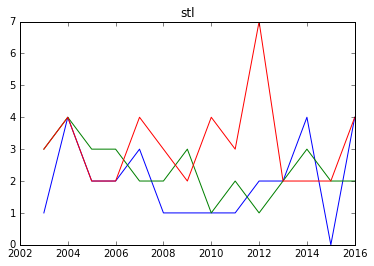

In [59]:
plotStatsList= plotDataTeam['stat'].unique()
for s in plotStatsList:
    plotData= plotDataTeam.filter_by(s,'stat')
    plt.plot(plotData['Season'], plotData['loc.A'])
    plt.plot(plotData['Season'], plotData['loc.H'])
    plt.plot(plotData['Season'], plotData['loc.N'])
    plt.title(s)
    plt.show()
    break
#plt.plot()

# Define basic plotting functions for visualization

In [66]:
def plotTeam(data,team,season):
    d= data.filter_by(team,'team')
    e= d.filter_by(season,'Season')
    
    plt.plot(e['game_seq'],e['score'])

In [64]:
rsdrTall.filter_by(1234,'team')['Season'].unique()

dtype: int
Rows: 14
[2011L, 2005L, 2010L, 2012L, 2004L, 2014L, 2013L, 2015L, 2007L, 2009L, 2006L, 2003L, 2008L, 2016L]

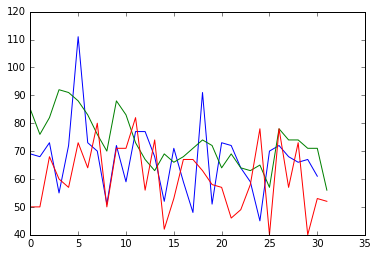

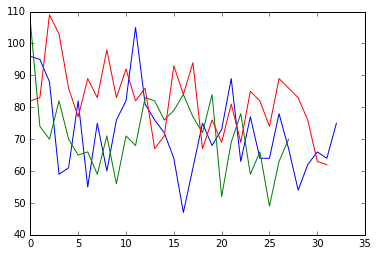

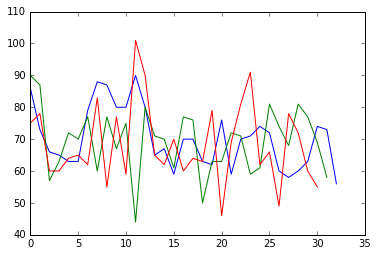

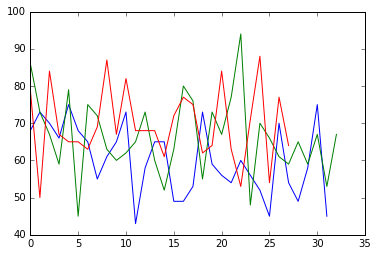

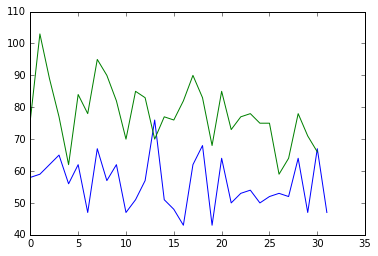

In [68]:
seasonsPlayed= rsdrTall.filter_by(1234,'team')['Season'].unique()
for i,season in enumerate(seasonsPlayed):
    if i%3 ==0: plt.show()
    plotTeam(rsdrTall,1234,season)